In [279]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import pprint

import pathlib
import logging

In [280]:
# Use start time from info file (instead of recording.meta_info.start_time_synced_ns)
# to have a more precise value and avoid having a negative first timestamp when rewriting
# start_time_synced_ns = int(info_json["start_time"])
# start_time_synced_ns = 1706217550686000000


def conversion(timestamps):
    # Subtract start_time from all times in the recording, so timestamps
    # start at 0. This is to increase precision when converting
    # timestamps to float32, e.g. for OpenGL!
    SECONDS_PER_NANOSECOND = 1e-9
    # return (timestamps - start_time_synced_ns) * SECONDS_PER_NANOSECOND
    return timestamps * SECONDS_PER_NANOSECOND

In [281]:
def _rewrite_times(path, dtype="<u8"):
    """Load raw times (assuming dtype), apply conversion and save as _timestamps.npy."""

    timestamps = np.fromfile(str(path), dtype=dtype)
    new_name = f"{path.stem}_timestamps_unix.npy"
    timestamp_loc = path.parent / new_name
    np.save(str(timestamp_loc), timestamps)

    timestamps = conversion(timestamps)

    new_name = f"{path.stem}_timestamps.npy"
    # logger.info(f"Creating {new_name}")
    timestamp_loc = path.parent / new_name
    np.save(str(timestamp_loc), timestamps)

In [282]:
def _load_timestamps_data(path):
    timestamps = np.load(str(path))
    return timestamps.astype(np.float64)

In [283]:
def _neon_raw_time_load(path):
    return np.fromfile(str(path), dtype="<u8")

In [284]:
def _load_raw_data(path):
    raw_data = np.fromfile(str(path), "<f4")
    raw_data_dtype = raw_data.dtype
    raw_data.shape = (-1, 2)
    return np.asarray(raw_data, dtype=raw_data_dtype)

In [285]:
def _load_worn_data(path: pathlib.Path):
    if not (path and path.exists()):
        return None

    confidences = np.fromfile(str(path), "<u1") / 255.0
    return np.clip(confidences, 0.0, 1.0)

In [286]:
# obtained here:
# https://github.com/pupil-labs/neon-player/blob/master/pupil_src/shared_modules/imu_timeline/imu_timeline.py#L72
from scipy.spatial.transform import Rotation

import imu_pb2

logger = logging.getLogger(__name__)


def parse_neon_imu_raw_packets(buffer):
    index = 0
    packet_sizes = []
    while True:
        nums = np.frombuffer(buffer[index : index + 2], np.uint16)
        if not nums:
            break
        index += 2
        packet_size = nums[0]
        packet_sizes.append(packet_size)
        packet_bytes = buffer[index : index + packet_size]
        index += packet_size
        packet = imu_pb2.ImuPacket()
        packet.ParseFromString(packet_bytes)
        yield packet


class IMURecording:
    DTYPE_RAW = np.dtype(
        [
            ("gyro_x", "<f4"),
            ("gyro_y", "<f4"),
            ("gyro_z", "<f4"),
            ("accel_x", "<f4"),
            ("accel_y", "<f4"),
            ("accel_z", "<f4"),
            ("pitch", "<f4"),
            ("yaw", "<f4"),
            ("roll", "<f4"),
            ("quaternion_w", "<f4"),
            ("quaternion_x", "<f4"),
            ("quaternion_y", "<f4"),
            ("quaternion_z", "<f4"),
            ("tsNs", "uint64"),
            ("ts", "<f8"),
            ("ts_rel", "<f8"),
        ]
    )

    def __init__(self, path_to_imu_raw: pathlib.Path, start_ts):
        stem = path_to_imu_raw.stem
        self.path_raw = path_to_imu_raw
        self.path_ts = path_to_imu_raw.with_name(stem + "_timestamps.npy")
        self.load(start_ts)

    def load(self, start_ts):
        if not self.path_raw.exists() and self.path_ts.exists():
            self.ts = np.empty(0, dtype=np.float64)
            self.raw = []
            return

        self.ts = np.load(str(self.path_ts))
        with self.path_raw.open("rb") as raw_file:
            raw_data = raw_file.read()
            imu_packets = parse_neon_imu_raw_packets(raw_data)
            imu_data = []
            for packet in imu_packets:
                rotation = Rotation.from_quat(
                    [
                        packet.rotVecData.x,
                        packet.rotVecData.y,
                        packet.rotVecData.z,
                        packet.rotVecData.w,
                    ]
                )
                euler = rotation.as_euler(seq="XZY", degrees=True)

                ts = conversion(float(packet.tsNs))
                ts_rel = ts - start_ts

                imu_data.append(
                    (
                        packet.gyroData.x,
                        packet.gyroData.y,
                        packet.gyroData.z,
                        packet.accelData.x,
                        packet.accelData.y,
                        packet.accelData.z,
                        *euler,
                        packet.rotVecData.w,
                        packet.rotVecData.x,
                        packet.rotVecData.y,
                        packet.rotVecData.z,
                        packet.tsNs,
                        ts,
                        ts_rel,
                    )
                )

            self.raw = np.array(imu_data, dtype=IMURecording.DTYPE_RAW).view(
                np.recarray
            )

        num_ts_during_init = self.ts.size - len(self.raw)
        if num_ts_during_init > 0:
            self.ts = self.ts[num_ts_during_init:]

In [287]:
start_ts = conversion(1706217550686000000)

with pathlib.Path(
    "../tests/test_data/2024-01-25_22-19-10_test-f96b6e36/extimu ps1.raw"
).open("rb") as raw_file:
    raw_data = raw_file.read()
    imu_packets = parse_neon_imu_raw_packets(raw_data)
    imu_data = []
    for packet in imu_packets:
        rotation = Rotation.from_quat(
            [
                packet.rotVecData.x,
                packet.rotVecData.y,
                packet.rotVecData.z,
                packet.rotVecData.w,
            ]
        )
        euler = rotation.as_euler(seq="XZY", degrees=True)

        ts = conversion(packet.tsNs)
        ts_rel = ts - start_ts

        imu_data.append(
            (
                packet.gyroData.x,
                packet.gyroData.y,
                packet.gyroData.z,
                packet.accelData.x,
                packet.accelData.y,
                packet.accelData.z,
                *euler,
                packet.rotVecData.w,
                packet.rotVecData.x,
                packet.rotVecData.y,
                packet.rotVecData.z,
                packet.tsNs,
                ts,
                ts_rel,
            )
        )

    raw = np.array(imu_data, dtype=IMURecording.DTYPE_RAW).view(np.recarray)

/var/folders/by/f4g6q8690z50zbfvy6kq71cc0000gn/T/ipykernel_25601/647576048.py:14: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not nums:


In [288]:
raw

rec.array([( 0.10108948, -0.53596497, 0.70762634, 0.04443359, -0.6230469 , 0.7832031 , -118.563385, -44.58207 , 124.69439 , 0.50820255, -0.1975484 , 0.2673142 , -0.7945111 , 1706217553148771064, 1.70621755e+09,  2.46277094),
           ( 0.2822876 , -0.47683716, 0.5893707 , 0.04882812, -0.6269531 , 0.78271484, -118.54282 , -44.59728 , 124.66329 , 0.5083921 , -0.19759709, 0.26724702, -0.7944003 , 1706217553159015064, 1.70621755e+09,  2.47301483),
           ( 0.2822876 , -0.11062622, 0.5245209 , 0.04150391, -0.62841797, 0.77539057, -118.5168  , -44.61387 , 124.62134 , 0.5086237 , -0.19768989, 0.26716286, -0.7942572 , 1706217553169259064, 1.70621755e+09,  2.48325872),
           ...,
           (-0.78201294, -2.6168823 , 2.653122  , 0.11816406, -0.8154297 , 0.5932617 , -107.888054, -33.64299 , 110.22006 , 0.51416355, -0.30293173, 0.32829908, -0.7321802 , 1706217591021952064, 1.70621759e+09, 40.33595181),
           (-1.2111664 , -2.2525787 , 2.7179718 , 0.12597656, -0.80615234, 0.6108398

In [289]:
_rewrite_times(
    pathlib.Path("../tests/test_data/2024-01-25_22-19-10_test-f96b6e36/extimu ps1.time")
)
imu_rec = IMURecording(
    pathlib.Path("../tests/test_data/2024-01-25_22-19-10_test-f96b6e36/extimu ps1.raw"),
    conversion(1706217550686000000),
)

/var/folders/by/f4g6q8690z50zbfvy6kq71cc0000gn/T/ipykernel_25601/647576048.py:14: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not nums:


In [290]:
[imu_rec.raw.ts[0], imu_rec.raw.ts[1]]

[1706217553.1487713, 1706217553.1590152]

In [291]:
gaze_ps1_raw = _load_raw_data(
    "../tests/test_data/2024-01-25_22-19-10_test-f96b6e36/gaze ps1.raw"
)
gaze_ps1_time = _neon_raw_time_load(
    "../tests/test_data/2024-01-25_22-19-10_test-f96b6e36/gaze ps1.time"
)

gaze_200hz_raw = _load_raw_data(
    "../tests/test_data/2024-01-25_22-19-10_test-f96b6e36/gaze_200hz.raw"
)
gaze_200hz_time = _neon_raw_time_load(
    "../tests/test_data/2024-01-25_22-19-10_test-f96b6e36/gaze_200hz.time"
)

gaze_right_ps1_raw = _load_raw_data(
    "../tests/test_data/2024-01-25_22-19-10_test-f96b6e36/gaze_right ps1.raw"
)
gaze_right_ps1_time = _neon_raw_time_load(
    "../tests/test_data/2024-01-25_22-19-10_test-f96b6e36/gaze_right ps1.time"
)

# '../tests/test_data/2024-01-25_22-19-10_test-f96b6e36/Neon Scene Camera v1 ps1.time'
# '../tests/test_data/2024-01-25_22-19-10_test-f96b6e36/Neon Scene Camera v1 ps1.time_aux'

# '../tests/test_data/2024-01-25_22-19-10_test-f96b6e36/Neon Sensor Module Camera v1 ps1.time'
# '../tests/test_data/2024-01-25_22-19-10_test-f96b6e36/Neon Sensor Module Camera v1 ps1.time_aux'

# imu_ps1_raw = _load_raw_data('../tests/test_data/2024-01-25_22-19-10_test-f96b6e36/extimu ps1.raw')
# imu_ps1_time = _neon_raw_time_load('../tests/test_data/2024-01-25_22-19-10_test-f96b6e36/extimu ps1.time')

worn_ps1_raw = _load_worn_data(
    pathlib.Path("../tests/test_data/2024-01-25_22-19-10_test-f96b6e36/worn ps1.raw")
)
# worn_200hz_raw = _neon_raw_time_load('../tests/test_data/2024-01-25_22-19-10_test-f96b6e36/worn_200hz.raw')

In [292]:
worn_ps1_raw

array([1., 1., 1., ..., 1., 1., 1.])

In [293]:
class Stream:
    def __init__(self, name):
        self.name = name
        self.data = []
        self.ts = []
        self.ts_rel = []

    def load(self, data):
        self.data = data[:]
        self.ts = data[:].ts
        self.ts_rel = data[:].ts_rel

    def sample(self, tstamps):
        if len(tstamps) == 1:
            if tstamps < self.ts[0]:
                self.closest_idxs = [None]

            if tstamps > self.ts[-1]:
                self.closest_idxs = [None]

            self.closest_idxs = np.searchsorted(self.ts, tstamps)

        sorted_tses = np.sort(tstamps)

        self.closest_idxs = []
        for tc in range(1, len(sorted_tses)):
            prev_ts = sorted_tses[tc - 1]
            curr_ts = sorted_tses[tc]

            bounded_tstamps = self.ts[(self.ts >= prev_ts) & (self.ts <= curr_ts)]

            if len(bounded_tstamps) == 0:
                self.closest_idxs.append(None)
                continue

            # just always take the one that is closest to the current timestamp
            closest_ts = bounded_tstamps[-1]

            # this has the feeling of suboptimal
            self.closest_idxs.append(np.where(self.ts == closest_ts)[0][0])

    def __iter__(self):
        self.idx = 0
        return self

    def __next__(self):
        if self.idx < len(self.closest_idxs):
            idx = self.closest_idxs[self.idx]

            if idx is None:
                self.idx += 1
                return None
            else:
                self.idx += 1
                return self.data[idx : idx + 1]
        else:
            raise StopIteration

In [294]:
# def sample(self, tstamps):
#     if len(tstamps) == 1:
#         if tstamps < self.ts[0]:
#             self.closest_idxs = [None]

#         if tstamps > self.ts[-1]:
#             self.closest_idxs = [None]

#         self.closest_idxs = np.searchsorted(self.ts, tstamps)

#     sorted_tses = np.sort(tstamps)

#     self.closest_idxs = []
#     for tc in range(1, len(sorted_tses)):
#         prev_ts = sorted_tses[tc - 1]
#         curr_ts = sorted_tses[tc]

#         bounded_tstamps = self.ts[(self.ts >= prev_ts) & (self.ts <= curr_ts)]

#         if len(bounded_tstamps) == 0:
#             self.closest_idxs.append(None)
#             continue

#         # just always take the one that is closest to the current timestamp
#         closest_ts = bounded_tstamps[-1]

#         # this has the feeling of suboptimal
#         self.closest_idxs.append(np.where(self.ts == closest_ts)[0][0])

# np.recarray.sample = sample

In [295]:
def convert_gaze_to_recarray(gaze_data, ts, ts_rel):
    out = np.recarray(
        gaze_data.shape[0],
        dtype=[("x", "<f4"), ("y", "<f4"), ("ts", "<f8"), ("ts_rel", "<f8")],
    )
    out.x = gaze_data[:, 0]
    out.y = gaze_data[:, 1]
    out.ts = ts.astype(np.float64)
    out.ts_rel = ts_rel.astype(np.float64)

    return out

In [296]:
ts

1706217591.04255

In [297]:
class NeonRecording:
    def __init__(self):
        self.info = []
        self._calib = []

        self.start_ts = 0

        self.scene_camera = []
        self.eye1_camera = []
        self.eye2_camera = []
        self.streams = {
            "gaze": Stream("gaze"),
            "imu": Stream("imu"),
            "scene": Stream("scene"),
        }

        self._gaze_ps1_raw_time = []
        self._gaze_200hz_raw_time = []
        self._gaze_right_ps1_raw_time = []
        self._gaze_ps1_ts = []
        self._gaze_ps1_raw = []
        self._gaze_right_ps1_ts = []
        self._gaze_right_ps1_raw = []
        self._worn_ps1_raw = []

    # TODO: save for the end
    def check(self):
        pass

    @property
    def gaze(self):
        return self.streams["gaze"]

    @property
    def imu(self):
        return self.streams["imu"]

    @property
    def scene(self):
        return self.streams["scene"]

    @staticmethod
    def load(rec_dir):
        rec = NeonRecording()

        with open(rec_dir + "/info.json") as f:
            rec.info = json.load(f)

        rec._start_ts_ns = rec.info["start_time"]
        rec.start_ts = conversion(rec.info["start_time"])

        with open(rec_dir + "calibration.bin", "rb") as f:
            raw_data = f.read()

        # obtained here:
        # https://github.com/pupil-labs/realtime-python-api/blob/main/src/pupil_labs/realtime_api/device.py#L178
        rec._calib = np.frombuffer(
            raw_data,
            np.dtype(
                [
                    ("version", "u1"),
                    ("serial", "6a"),
                    ("scene_camera_matrix", "(3,3)d"),
                    ("scene_distortion_coefficients", "8d"),
                    ("scene_extrinsics_affine_matrix", "(4,4)d"),
                    ("right_camera_matrix", "(3,3)d"),
                    ("right_distortion_coefficients", "8d"),
                    ("right_extrinsics_affine_matrix", "(4,4)d"),
                    ("left_camera_matrix", "(3,3)d"),
                    ("left_distortion_coefficients", "8d"),
                    ("left_extrinsics_affine_matrix", "(4,4)d"),
                    ("crc", "u4"),
                ]
            ),
        )

        # rec.version = rec._calib['version']
        rec.serial = rec._calib["serial"]
        rec.scene_camera = {
            "matrix": rec._calib["scene_camera_matrix"],
            "distortion": rec._calib["scene_distortion_coefficients"],
            "extrinsics": rec._calib["scene_extrinsics_affine_matrix"],
        }
        rec.eye1_camera = {
            "matrix": rec._calib["right_camera_matrix"],
            "distortion": rec._calib["right_distortion_coefficients"],
            "extrinsics": rec._calib["right_extrinsics_affine_matrix"],
        }
        rec.eye2_camera = {
            "matrix": rec._calib["left_camera_matrix"],
            "distortion": rec._calib["left_distortion_coefficients"],
            "extrinsics": rec._calib["left_extrinsics_affine_matrix"],
        }

        rec._gaze_ps1_raw_time = _neon_raw_time_load(rec_dir + "/gaze ps1.time")
        rec._gaze_200hz_raw_time = _neon_raw_time_load(rec_dir + "/gaze_200hz.time")
        rec._gaze_right_ps1_raw_time = _neon_raw_time_load(
            rec_dir + "/gaze_right ps1.time"
        )

        _rewrite_times(pathlib.Path(rec_dir + "/gaze ps1.time"))
        rec._gaze_ps1_ts = _load_timestamps_data(
            pathlib.Path(rec_dir + "/gaze ps1_timestamps.npy")
        )
        rec._gaze_ps1_raw = _load_raw_data(rec_dir + "/gaze ps1.raw")

        _rewrite_times(pathlib.Path(rec_dir + "/gaze_200hz.time"))
        gaze_200hz_ts = _load_timestamps_data(
            pathlib.Path(rec_dir + "/gaze_200hz_timestamps.npy")
        )
        gaze_200hz_raw = _load_raw_data(rec_dir + "/gaze_200hz.raw")

        gaze_200hz_ts_rel = gaze_200hz_ts - rec.start_ts
        rec.streams["gaze"].load(
            convert_gaze_to_recarray(gaze_200hz_raw, gaze_200hz_ts, gaze_200hz_ts_rel)
        )

        _rewrite_times(pathlib.Path(rec_dir + "/gaze_right ps1.time"))
        rec._gaze_right_ps1_ts = _load_timestamps_data(
            pathlib.Path(rec_dir + "/gaze_right ps1_timestamps.npy")
        )
        rec._gaze_right_ps1_raw = _load_raw_data(rec_dir + "/gaze_right ps1.raw")

        _rewrite_times(pathlib.Path(rec_dir + "/extimu ps1.time"))
        imu_rec = IMURecording(pathlib.Path(rec_dir + "/extimu ps1.raw"), rec.start_ts)
        rec.streams["imu"].load(imu_rec.raw)

        rec._worn_ps1_raw = _load_worn_data(pathlib.Path(rec_dir + "/worn ps1.raw"))
        # worn_ps1_raw = _load_worn_data(pathlib.Path(rec_dir + '/worn_200hz.raw'))

        return rec

In [298]:
rec = NeonRecording.load("../tests/test_data/2024-01-25_22-19-10_test-f96b6e36/")

/var/folders/by/f4g6q8690z50zbfvy6kq71cc0000gn/T/ipykernel_25601/647576048.py:14: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not nums:


In [299]:
gs = rec.streams["gaze"]
ts = rec.streams["gaze"].ts
gs.sample([ts[0], ts[1], ts[2]])

for g in gs:
    print(g)

[(804.34216, 806.01044, 1.70621755e+09, 2.608845)]
[(802.19934, 807.4595, 1.70621755e+09, 2.61384869)]


In [300]:
rec.info
pprint.pprint(rec.info)

{'android_device_id': '6296df393d96a031',
 'android_device_model': 'rtwo_ge',
 'android_device_name': 'Neon Companion',
 'app_version': '2.7.10-prod',
 'calib_version': 1,
 'data_format_version': '2.2',
 'duration': 40252000000,
 'firmware_version': [29, 8],
 'frame_id': '1',
 'frame_name': 'Just act natural',
 'gaze_frequency': 200,
 'gaze_offset': [0.0, 0.0],
 'module_serial_number': '619453',
 'os_version': '13',
 'pipeline_version': '2.6.0',
 'recording_id': 'f96b6e36-6c98-409c-be7c-46c3e408acb2',
 'start_time': 1706217550686000000,
 'template_data': {'data': {'c700c50c-cee1-45fb-b459-050e5ceeaeae': ['']},
                   'id': '94733ede-ce4c-46be-aa72-7bb80e21bfe6',
                   'recording_name': '2024-01-25_22:19:10',
                   'version': '2024-01-25T09:33:35.681129Z'},
 'wearer_id': '65aee704-fa44-4fec-a811-6b4b126afdb0',
 'wearer_ied': 63.0,
 'workspace_id': 'e8984f4b-fe9f-48f5-bf3e-46e1ae0669b8'}


In [301]:
rec._calib

array([(1, b'619453', [[885.15825992,   0.        , 824.12887524], [  0.        , 885.14923875, 612.28065252], [  0.        ,   0.        ,   1.        ]], [-0.13053092,  0.10917948, -0.0001823 , -0.00043524,  0.00068462,  0.17075814,  0.05227603,  0.02661005], [[1., 0., 0., 0.], [0., 1., 0., 0.], [0., 0., 1., 0.], [0., 0., 0., 1.]], [[139.37418637,   0.        ,  99.23202584], [  0.        , 139.35188665,  96.19039145], [  0.        ,   0.        ,   1.        ]], [ 3.68394045e-02, -1.23725784e-01,  1.05156082e-03, -6.51159021e-04, -6.49958070e-01, -5.22825142e-02,  9.73858508e-03, -6.94081020e-01], [[-0.82693827,  0.18204613,  0.53200775, 16.86289978], [ 0.07135105,  0.9724648 , -0.22185867, 19.95415497], [-0.55774736, -0.14550412, -0.81715757, -7.03173828], [ 0.        ,  0.        ,  0.        ,  1.        ]], [[139.02147562,   0.        ,  93.94689674], [  0.        , 139.25351257,  96.6396657 ], [  0.        ,   0.        ,   1.        ]], [ 0.05170779, -0.11790007, -0.00186199, 

In [302]:
rec.streams

{'gaze': <__main__.Stream at 0x291d70150>,
 'imu': <__main__.Stream at 0x293c14650>,
 'scene': <__main__.Stream at 0x2a3649110>}

In [303]:
rec.streams["gaze"].data

rec.array([(806.6711 ,  806.5423 , 1.70621755e+09,  2.60384369),
           (804.34216,  806.01044, 1.70621755e+09,  2.608845  ),
           (802.19934,  807.4595 , 1.70621755e+09,  2.61384869), ...,
           (883.96313, 1085.5363 , 1.70621759e+09, 40.2386837 ),
           (887.2845 , 1084.7004 , 1.70621759e+09, 40.24368477),
           (884.99097, 1087.0084 , 1.70621759e+09, 40.24882483)],
          dtype=[('x', '<f4'), ('y', '<f4'), ('ts', '<f8'), ('ts_rel', '<f8')])

In [304]:
rec.start_ts

1706217550.6860003

In [305]:
rec.streams["gaze"].data.ts[0] - rec.start_ts

2.6038436889648438

In [306]:
rec.streams["gaze"].data.ts_rel

array([ 2.60384369,  2.608845  ,  2.61384869, ..., 40.2386837 ,
       40.24368477, 40.24882483])

In [307]:
rec.streams["imu"].data.ts

array([1.70621755e+09, 1.70621755e+09, 1.70621755e+09, ...,
       1.70621759e+09, 1.70621759e+09, 1.70621759e+09])

In [308]:
[rec.streams["imu"].data.ts[0], rec.streams["imu"].data.ts[1]]

[1706217553.1487713, 1706217553.1590152]

In [309]:
for stream in rec.streams:
    s = rec.streams[stream]
    name = s.name
    print(name)
    avg_spf = (s.data.ts[-1] - s.data.ts[0]) / len(s.data.ts)
    avg_fps = 1 / avg_spf
    print(avg_fps)
    start_offset = s.data.ts[0] - rec.start_ts
    print(start_offset)
    print()

gaze
198.69846583315015
2.6038436889648438

imu
104.15957776951906
2.462770938873291

scene


AttributeError: 'list' object has no attribute 'ts'

In [310]:
np.all((rec.gaze.data == rec.streams["gaze"].data).flatten())

rec.array(True,
          dtype=bool)

In [311]:
np.all((rec.imu.data == rec.streams["imu"].data).flatten())

rec.array(True,
          dtype=bool)

In [312]:
rec.gaze.ts

array([1.70621755e+09, 1.70621755e+09, 1.70621755e+09, ...,
       1.70621759e+09, 1.70621759e+09, 1.70621759e+09])

In [313]:
np.all((rec.gaze.ts == rec.streams["gaze"].ts).flatten())

True

In [314]:
np.all((rec.imu.ts == rec.streams["imu"].ts).flatten())

True

In [315]:
np.all(rec.imu.ts_rel == rec.streams["imu"].ts_rel)

True

In [316]:
np.all(rec.gaze.ts_rel == rec.streams["gaze"].ts_rel)

True

In [317]:
# adapted from here:
# https://github.com/pupil-labs/neon-player/blob/master/pupil_src/shared_modules/pupil_recording/update/neon.py#L181

rec_dir = "../tests/test_data/2024-01-25_22-19-10_test-f96b6e36/"
rec_path = pathlib.Path(rec_dir)

labels = (rec_path / "event.txt").read_text().strip().split("\n")

_rewrite_times(pathlib.Path(rec_dir + "/event.time"))
timestamps = np.load(rec_path / "event_timestamps.npy")
timestamps_unix = np.load(rec_path / "event_timestamps_unix.npy")

In [318]:
labels

['recording.begin', 'recording.end']

In [319]:
timestamps

array([1.70621755e+09, 1.70621759e+09])

In [320]:
timestamps_unix

array([1706217550686000000, 1706217590938000000], dtype=uint64)

In [321]:
events = [evt for evt in zip(labels, timestamps)]
events

[('recording.begin', 1706217550.6860003), ('recording.end', 1706217590.938)]

In [322]:
unique_events = dict(events)
unique_events

{'recording.begin': 1706217550.6860003, 'recording.end': 1706217590.938}

In [323]:
unique_events["recording.begin"]

1706217550.6860003

In [324]:
t = [
    ("rec.b", 1706217550.6860003),
    ("rec.b", 1706217888.6860003),
    ("rec.c", 1706218888.938),
    ("rec.c", 1706217590.938),
]
t

[('rec.b', 1706217550.6860003),
 ('rec.b', 1706217888.6860003),
 ('rec.c', 1706218888.938),
 ('rec.c', 1706217590.938)]

In [325]:
t.reverse()
t

[('rec.c', 1706217590.938),
 ('rec.c', 1706218888.938),
 ('rec.b', 1706217888.6860003),
 ('rec.b', 1706217550.6860003)]

In [326]:
dict(t)

{'rec.c': 1706218888.938, 'rec.b': 1706217550.6860003}

In [327]:
import pupil_labs.neon_recording as nr

rec = nr.load("../tests/test_data/2024-01-25_22-19-10_test-f96b6e36/")

gaze_data = rec.streams["gaze"].data
gaze_ts = rec.streams["gaze"].ts
gaze_start_offset = rec.streams["gaze"].data.ts[0] - rec.start_ts
# there is also rec.streams['gaze'].ts_rel

gaze = rec.streams["gaze"]
gaze.sample([gaze_ts[0], gaze_ts[1], gaze_ts[2]])

for g in gaze:
    if g:
        print(g.x, g.y, g.ts)

print()
sample_ts = gaze_ts[:15]
for gaze, imu in zip(rec.gaze.sample(sample_ts), rec.imu.sample(sample_ts)):
    if gaze:
        x = gaze.x
        y = gaze.y
        ts = gaze.ts

        print("gz", x, y, ts)

    if imu:
        pitch = imu.pitch
        yaw = imu.yaw
        roll = imu.roll
        ts = imu.ts

        print("imu", pitch, yaw, roll, ts)

NeonRecording: Loading recording from: ../tests/test_data/2024-01-25_22-19-10_test-f96b6e36
NeonRecording: Loading recording info and calibration data
NeonRecording: Loading raw time files
NeonRecording: Loading 'gaze ps1' data
NeonRecording: Loading 'gaze_200hz' data
NeonRecording: Loading 'gaze_right_ps1' data
NeonRecording: Loading IMU data
NeonRecording: Loading events
NeonRecording: Parsing unique events
NeonRecording: Finished loading recording.

[804.34216309] [806.01043701] [1.70621755e+09]
[802.19934082] [807.45947266] [1.70621755e+09]

gz [804.34216309] [806.01043701] [1.70621755e+09]
gz [802.19934082] [807.45947266] [1.70621755e+09]
imu [-118.25288] [-44.7666] [124.22863] [1.70621755e+09]
gz [800.52740479] [803.5536499] [1.70621755e+09]
gz [804.71148682] [802.50836182] [1.70621755e+09]
imu [-118.21066] [-44.766228] [124.16915] [1.70621755e+09]
gz [804.94714355] [802.89910889] [1.70621755e+09]
gz [803.04333496] [808.11279297] [1.70621755e+09]
gz [805.105896] [805.82208252] [1

In [328]:
rec.gaze.sample([gaze_ts[0], gaze_ts[1], gaze_ts[2]])
for g in rec.gaze.try_generator():
    print(g)

AttributeError: 'Stream' object has no attribute 'try_generator'

In [329]:
rec.imu.sample_one(gaze_ts[0])

(-0.81443787, -1.1463165, -0.45204163, 0.04101563, -0.6098633, 0.7675781, -118.2757, -44.769444, 124.262, 0.51070815, -0.19833069, 0.26649785, -0.79298234, 1706217553288873064, 1.70621755e+09, 2.60287261)

In [330]:
rec.gaze.to_numpy()

array([[8.04342163e+02, 8.06010437e+02, 1.70621755e+09, 2.60884500e+00],
       [8.02199341e+02, 8.07459473e+02, 1.70621755e+09, 2.61384869e+00]])

In [331]:
import os

os.environ["LD_LIBRARY_PATH"] = "/opt/homebrew/lib"

import pupil_labs.video as pv
import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt

mfname = (
    "../tests/test_data/2024-01-25_22-19-10_test-f96b6e36/Neon Scene Camera v1 ps1.mp4"
)
# for frame in tqdm.tqdm(pv.open(mfname).decode(video=0)):
# frame.to_ndarray(format='bgr24')

In [332]:
eye_container = pv.open(
    "../tests/test_data/2024-01-25_22-19-10_test-f96b6e36/Neon Sensor Module v1 ps1.mp4"
)
scene_container = pv.open(
    "../tests/test_data/2024-01-25_22-19-10_test-f96b6e36/Neon Scene Camera v1 ps1.mp4"
)

In [333]:
scene_container

<InputContainer('../tests/test_data/2024-01-25_22-19-10_test-f96b6e36/Neon Scene Camera v1 ps1.mp4', writeable=False, streams=StreamsContainer((<AudioStream('../tests/test_data/2024-01-25_22-19-10_test-f96b6e36/Neon Scene Camera v1 ps1.mp4' index=0 aac <av.AudioFormat fltp>)>, <VideoStream('../tests/test_data/2024-01-25_22-19-10_test-f96b6e36/Neon Scene Camera v1 ps1.mp4' index=1 h264 <av.VideoFormat yuv420p, 1600x1200>)>)))>

In [334]:
scene_container.seek_to_time(20)

In [337]:
len(scene_container.streams.video[0].frames), len(scene_time)

(1162, 1162)

In [348]:
rec.start_ts, st * 1e-9, st * 1e-9 - rec.start_ts

(1706217550.6860003, 1706217590.8706603, 40.18465995788574)

In [364]:
eye_container.streams.video[0].seek_to_index(42)

In [366]:
eye_container.streams.video[0].

TypeError: VideoStream.decode() got an unexpected keyword argument 'video'

In [363]:
eye_container = pv.open(
    "../tests/test_data/2024-01-25_22-19-10_test-f96b6e36/Neon Sensor Module v1 ps1.mp4"
)
for f, st in zip(eye_container.streams.video[0].frames, eye_time):
    print(f.time, (st * 1e-9 - rec.start_ts - 2.603))

0.0 0.0008436889648435475
0.005 0.005844995498657024
0.01 0.010848686218261516
0.015 0.01584474754333476
0.02 0.020844861984252727
0.025 0.025847837448119915
0.03 0.030844852447509563
0.035 0.03584472846984843
0.04 0.0408448429107664
0.23513333333333333 0.2359728069305418
0.24013333333333334 0.24097387504577616
0.24513333333333334 0.24597303581237773
0.2501333333333333 0.2509729118347166
0.2551333333333333 0.2559818477630613
0.2601333333333333 0.26097385597228984
0.26513333333333333 0.2659737319946287
0.27013333333333334 0.2709738464355467
0.27525555555555553 0.27609865379333476
0.28026666666666666 0.2811059207916258
0.2852777777777778 0.2860988826751707
0.2902888888888889 0.29109875869750956
0.2953 0.29609887313842753
0.3003111111111111 0.30110900115966777
0.3053222222222222 0.30609886360168437
0.31033333333333335 0.31109873962402323
0.3153444444444444 0.3160998077392576
0.32025555555555557 0.3210996837615965
0.32516666666666666 0.3261067123413084
0.3302555555555556 0.3310999126434324

In [359]:
scene_container = pv.open(
    "../tests/test_data/2024-01-25_22-19-10_test-f96b6e36/Neon Scene Camera v1 ps1.mp4"
)
for f, st in zip(scene_container.streams.video[0].frames, scene_time):
    print(f.time, (st * 1e-9 - rec.start_ts - 1.494))

0.0 2.070045471191939e-05
0.0134 0.013421731948852544
0.04674444444444444 0.04676480865478516
0.08008888888888889 0.08010669326782227
0.11343333333333333 0.11344976997375489
0.14677777777777778 0.1467918930053711
0.1801222222222222 0.1801340160369873
0.21346666666666667 0.21347685432434083
0.24681111111111112 0.24681873893737794
0.28015555555555555 0.28016181564331055
0.3135 0.31350370025634766
0.34684444444444446 0.3468467769622803
0.3801888888888889 0.3801888999938965
0.4135333333333333 0.4135319766998291
0.44687777777777776 0.4468738613128662
0.4802222222222222 0.4802157459259033
0.5135666666666666 0.5135588226318359
0.5469111111111111 0.546900707244873
0.5802555555555555 0.5802437839508057
0.6136 0.6135859069824219
0.6469444444444444 0.6469289836883545
0.6802888888888889 0.6802708683013916
0.7136333333333333 0.7136139450073242
0.7469777777777777 0.7469558296203613
0.7803222222222223 0.7802977142333984
0.8136666666666666 0.8136407909393311
0.8470111111111112 0.8469829139709473
0.880

In [257]:
*x = next(d)
x

<av.Packet of #1, dts=22213, pts=22213; 22846 bytes at 0x177149710>

In [263]:
x.stream

<av.VideoStream #1 h264, yuv420p 1600x1200 at 0x17714ad40>

In [336]:
scene_time = _neon_raw_time_load(
    "../tests/test_data/2024-01-25_22-19-10_test-f96b6e36/Neon Scene Camera v1 ps1.time"
)
scene_time_aux = _neon_raw_time_load(
    "../tests/test_data/2024-01-25_22-19-10_test-f96b6e36/Neon Scene Camera v1 ps1.time_aux"
)

[13401000 33343000 33342000 ... 33342000 33343000 33342000]


(33000000.0, 35000000.0)

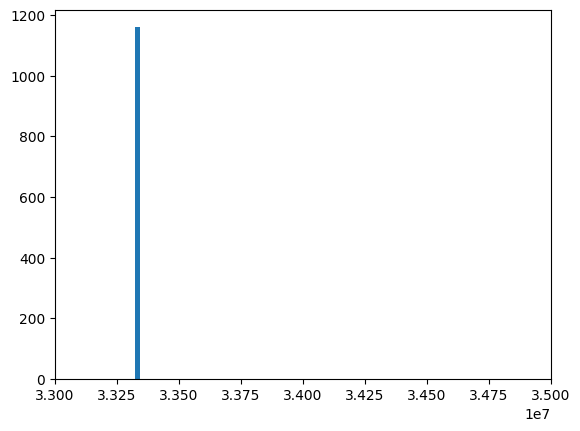

In [110]:
print(np.diff(scene_time))
plt.hist(np.diff(scene_time), bins=1000)
plt.xlim(33000000, 35000000)

[13401000 33343000 33342000 ... 33342000 33343000 33342000]


(33000000.0, 35000000.0)

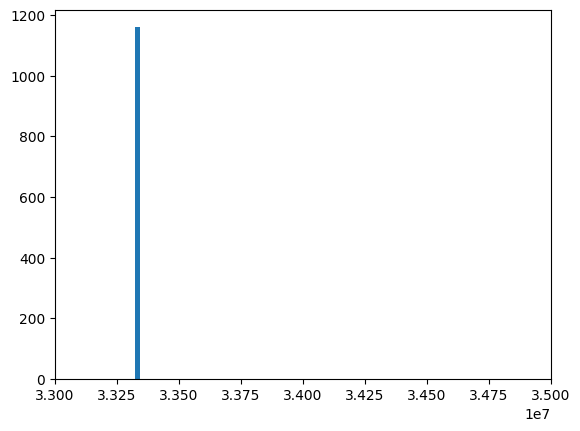

In [111]:
print(np.diff(scene_time))
plt.hist(np.diff(scene_time), bins=1000)
plt.xlim(33000000, 35000000)

In [361]:
eye_time = _neon_raw_time_load(
    "../tests/test_data/2024-01-25_22-19-10_test-f96b6e36/Neon Sensor Module v1 ps1.time"
)
eye_time_aux = _neon_raw_time_load(
    "../tests/test_data/2024-01-25_22-19-10_test-f96b6e36/Neon Sensor Module v1 ps1.time_aux"
)

[5001000 5004000 4996000 ... 5140000 4985000 5000000]


(0.0, 6000000.0)

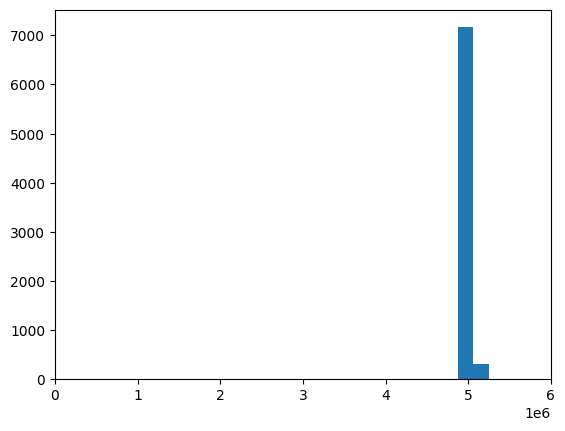

In [95]:
print(np.diff(eye_time))
plt.hist(np.diff(eye_time), bins=1000)
plt.xlim(0, 6000000)

[3139000 6236000 6253000 ... 6257000 6294000 3112000]


(0.0, 7000000.0)

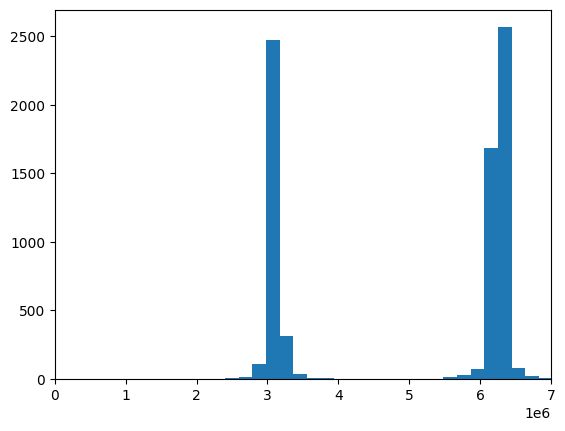

In [101]:
print(np.diff(eye_time_aux))
plt.hist(np.diff(eye_time_aux), bins=1000)
plt.xlim(0, 7000000)

In [72]:
frame.pts

23412

In [75]:
# dts = [frame.dts for frame in eye_container]
pts = [frame.pts for frame in eye_container]

In [76]:
pts

[0,
 450,
 900,
 1350,
 1800,
 2250,
 2700,
 3150,
 3600,
 21162,
 21612,
 22062,
 22512,
 22962,
 23412,
 23862,
 24312,
 24773,
 25224,
 25675,
 26126,
 26577,
 27028,
 27479,
 27930,
 28381,
 28823,
 29265,
 29723,
 30181,
 30623,
 31065,
 31523,
 31981,
 32423,
 32865,
 33323,
 33781,
 34223,
 34665,
 35123,
 35581,
 36023,
 36465,
 36934,
 37384,
 37834,
 38284,
 38734,
 39184,
 39634,
 40084,
 40534,
 40984,
 41434,
 41884,
 42334,
 42784,
 43234,
 43684,
 44134,
 44584,
 45034,
 45484,
 45934,
 46384,
 46834,
 47284,
 47734,
 48184,
 48634,
 49084,
 49546,
 49996,
 50446,
 50896,
 51346,
 51796,
 52246,
 52696,
 53146,
 53596,
 54046,
 54496,
 54946,
 55396,
 55846,
 56296,
 56746,
 57196,
 57646,
 58096,
 58546,
 58996,
 59446,
 59896,
 60346,
 60796,
 61246,
 61707,
 62157,
 62607,
 63057,
 63507,
 63957,
 64407,
 64857,
 65307,
 65757,
 66207,
 66657,
 67107,
 67557,
 68007,
 68457,
 68907,
 69357,
 69807,
 70257,
 70707,
 71157,
 71607,
 72057,
 72507,
 72957,
 73407,
 73869

[450 450 450 ... 462 449 449]


(0.0, 600.0)

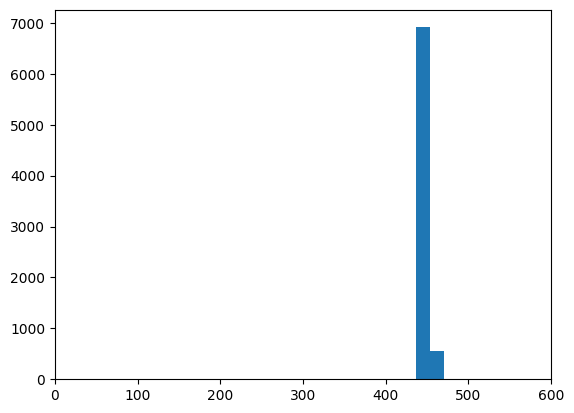

In [80]:
print(np.diff(pts))
plt.hist(np.diff(pts), bins=1000)
plt.xlim(0, 600)

[450 450 450 ... 462 449 449]


(0.0, 600.0)

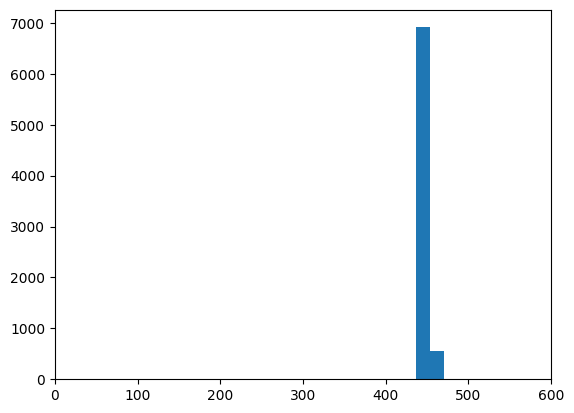

In [82]:
print(np.diff(dts))
plt.hist(np.diff(dts), bins=1000)
plt.xlim(0, 600)

deprecated pixel format used, make sure you did set range correctly
No accelerated colorspace conversion found from yuv420p to rgb24.


23412


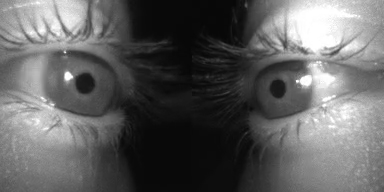

In [52]:
frame = next(eye_container)
print(frame.dts)
frame.pil

In [111]:
scene_container.duration_secs

38.723978

In [108]:
scene_container.start_time

0

In [110]:
eye_container.duration_secs

37.659189

In [109]:
eye_container.start_time

0

In [105]:
frame = next(scene_container)
print(frame.dts)
frame.pil

116837


AttributeError: 'AudioFrame' object has no attribute 'pil'

In [6]:
import pupil_labs.neon_recording as nr

rec = nr.load("../tests/test_data/2024-01-25_22-19-10_test-f96b6e36/")

scene_data = rec.streams["eye"].data
scene_ts = rec.streams["eye"].ts
scene_start_offset = rec.streams["eye"].ts[0] - rec.start_ts
# there is also rec.streams['gaze'].ts_rel

scene = rec.streams["eye"]
scene.sample([scene_ts[0], scene_ts[1], scene_ts[2]])

No accelerated colorspace conversion found from yuv420p to bgr24.


NeonRecording: Loading recording from: ../tests/test_data/2024-01-25_22-19-10_test-f96b6e36
NeonRecording: Loading recording info and calibration data
NeonRecording: Loading raw time files
NeonRecording: Loading 'gaze ps1' data
NeonRecording: Loading 'gaze_200hz' data
NeonRecording: Loading 'gaze_right_ps1' data
NeonRecording: Loading IMU data
NeonRecording: Loading scene camera video
NeonRecording: Loading eye camera video
NeonRecording: Loading events
NeonRecording: Parsing unique events
NeonRecording: Finished loading recording.



In [21]:
t = scene[20]
t.pts

26126

In [7]:
for s in scene:
    print(s.gray.shape)

loaded pts till 0


(192, 384)
(192, 384)


In [1]:
import numpy as np


def find_slice_indices(data, bounds):
    slice_indices = []
    for i in range(len(bounds) - 1):
        a, b = bounds[i], bounds[i + 1]
        # Use np.where to find indices of data elements that fall between a and b
        indices = np.where((data > a) & (data < b))[
            0
        ]  # np.where returns a tuple, [0] gets the array of indices
        slice_indices.append(indices)
    return slice_indices


# Example numpy array of data
data = np.array([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20])

# Example list of bounds (must be sorted)
bounds = [3, 7, 15]

# Find the slice indices
slice_indices = find_slice_indices(data, bounds)

# Display the results
for i, indices in enumerate(slice_indices, 1):
    print(f"Slice {i} Indices: {indices}")

Slice 1 Indices: [2 3]
Slice 2 Indices: [4 5 6 7]


In [2]:
import numpy as np


def find_slice_indices(data, bounds):
    # Use np.searchsorted to find the insertion points for all bounds at once
    start_indices = np.searchsorted(data, bounds, side="left")
    end_indices = np.searchsorted(data, bounds, side="right")[
        1:
    ]  # Shift to align with start_indices for slicing

    # Initialize a list to hold the slice indices
    slice_indices = []
    for start, end in zip(start_indices, np.append(end_indices, len(data))):
        # Generate the range of indices for this slice, if start is not equal to end
        if start != end:
            indices = np.arange(start, end)
            slice_indices.append(indices)

    return slice_indices[
        :-1
    ]  # the last one is not needed because we only want the bounded matches


# Example numpy array of data
data = np.array([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20])

# Example list of bounds (must be sorted)
bounds = [1, 18.1, 20]

# Find the slice indices
slice_indices = find_slice_indices(data, bounds)

# Display the results
for i, indices in enumerate(slice_indices, 1):
    print(f"Slice {i} Indices: {indices}")

Slice 1 Indices: [1 2 3 4 5 6 7 8 9]
Slice 2 Indices: [10]


In [8]:
t = []
s = [1, 2, 3]
c = [3, 4, 5]

t.extend(s)
t.extend(c)

t

[1, 2, 3, 3, 4, 5]

In [ ]:
import pupil_labs.neon_recording as nr

rec = nr.load("../tests/test_data/2024-01-25_22-19-10_test-f96b6e36/")

scene_data = rec.streams["eye"].data
scene_ts = rec.streams["eye"].ts
scene_start_offset = rec.streams["eye"].ts[0] - rec.start_ts
# there is also rec.streams['gaze'].ts_rel

scene = rec.streams["eye"]
scene.sample([scene_ts[0], scene_ts[1], scene_ts[2]])

In [39]:
import numpy as np

a = np.array([1, 2, 3.1, 4.0, 4.2, 5, 6, 7, 8, 9, 10])
b = np.array([2.6, 3.9, 4.1, 4.16])

left = np.searchsorted(a, b, side="left")
right = np.searchsorted(a, b, side="left")[1:]

In [41]:
c = a - b[:, np.newaxis]
idxs = np.argmin(np.abs(c), axis=1)
idxs

array([2, 3, 3, 4])

In [54]:
c

array([[-1.6 , -0.6 ,  0.5 ,  1.4 ,  1.6 ,  2.4 ,  3.4 ,  4.4 ,  5.4 ,
         6.4 ,  7.4 ],
       [-2.9 , -1.9 , -0.8 ,  0.1 ,  0.3 ,  1.1 ,  2.1 ,  3.1 ,  4.1 ,
         5.1 ,  6.1 ],
       [-3.1 , -2.1 , -1.  , -0.1 ,  0.1 ,  0.9 ,  1.9 ,  2.9 ,  3.9 ,
         4.9 ,  5.9 ],
       [-3.16, -2.16, -1.06, -0.16,  0.04,  0.84,  1.84,  2.84,  3.84,
         4.84,  5.84]])

In [80]:
(a[idxs[2] - 1] - a[idxs[2]]) / 2

-0.44999999999999996

In [79]:
(a[idxs[2]] - a[idxs[2]] + 1) / 2

0.5

In [83]:
b[0] - [a[idxs[0] - 1], a[idxs[0]], a[idxs[0] + 1]]

array([ 0.6, -0.5, -1.4])

In [82]:
a[idxs[0] - 1], b[0], a[idxs[0]], a[idxs[0] + 1]

(2.0, 2.6, 3.1, 4.0)

In [84]:
b[2] - [a[idxs[2] - 1], a[idxs[2]], a[idxs[2] + 1]]

array([ 1. ,  0.1, -0.1])

In [72]:
a[idxs[2] - 1], a[idxs[2]], b[2], a[idxs[2] + 1]

(3.1, 4.0, 4.1, 4.2)

In [68]:
c[2, idxs[2] - 1], c[2, idxs[2]], c[2, idxs[2] + 1]

(-0.9999999999999996, -0.09999999999999964, 0.10000000000000053)

In [64]:
c[2, idxs[2]] - c[2, idxs[2] + 1]

-0.20000000000000018

In [94]:
import numpy as np

a = np.array([1, 2, 3.1, 4.0, 4.2, 5, 6, 7, 8, 9, 10])
b = np.array([2.6, 3.9, 4.1, 4.16])

c = a - b[:, np.newaxis]
idxs = np.argmin(np.abs(c), axis=1)

for ic in range(len(idxs)):
    d = b[ic] - a[idxs[ic]]
    if np.sign(d) == +1:
        print([a[idxs[ic]], b[ic], a[idxs[ic] + 1]])
    else:
        print([a[idxs[ic] - 1], b[ic], a[idxs[ic]]])

[2.0, 2.6, 3.1]
[3.1, 3.9, 4.0]
[4.0, 4.1, 4.2]
[4.0, 4.16, 4.2]


In [100]:
import numpy as np

a = np.array([1, 2, 3.1, 4.0, 4.2, 5, 6, 7, 8, 9, 10])
b = np.array([2.6, 3.9, 4.1, 4.16])

c = a - b[:, np.newaxis]
idxs = np.argmin(np.abs(c), axis=1)

for ic, ix in enumerate(idxs):
    m = b[ic]
    d = m - a[ix]

    if np.sign(d) == +1:
        l = a[ix]
        r = a[ix + 1]
    else:
        l = a[ix - 1]
        r = a[ix]

    A = (m - l) / (r - l)
    print([l, m, r], A)

[2.0, 2.6, 3.1] 0.5454545454545455
[3.1, 3.9, 4.0] 0.8888888888888887
[4.0, 4.1, 4.2] 0.4999999999999978
[4.0, 4.16, 4.2] 0.8


In [112]:
dat = np.array([1, 2, 3, 4.0, 5, 6, 7, 8, 9, 10, 11])
t = np.interp(b, a, dat)
t

array([2.54545455, 3.88888889, 4.5       , 4.8       ])

In [101]:
t = [1, 2, 3]
t[None]

TypeError: list indices must be integers or slices, not NoneType

In [28]:
a - b[0]

array([-1.6, -0.6,  0.5,  1.4,  1.6,  2.4,  3.4,  4.4,  5.4,  6.4,  7.4])

In [2]:
gaze_ts

array([1.70621755e+09, 1.70621755e+09, 1.70621755e+09, ...,
       1.70621759e+09, 1.70621759e+09, 1.70621759e+09])

In [7]:
import numpy as np
import pupil_labs.neon_recording as nr

rec = nr.load("../tests/test_data/2024-01-25_22-19-10_test-f96b6e36/")

gaze_data = rec.streams["gaze"].data
gaze_ts = rec.streams["gaze"].ts
gaze_start_offset = rec.streams["gaze"].ts[0] - rec.start_ts
# there is also rec.streams['gaze'].ts_rel

samp_ts = gaze_ts[:15] + np.concatenate(
    [np.array([0]), np.random.uniform(-0.0001, 0.0001, 13), np.array([0])]
)

gaze = rec.streams["gaze"]
d0 = gaze.sample_rob_orig(samp_ts)
d1 = gaze.sample_rob(samp_ts)
d2 = gaze.sample(samp_ts)
d3 = gaze.sample(samp_ts, method="linear")
d4 = gaze.sample_rob_interp(samp_ts)
d5 = gaze.sample_mpk(samp_ts)
d6 = gaze.sample_rob_broadcast(samp_ts)

2024-03-08T14:44:32.388657Z [info     ] NeonRecording: Loading recording from: ../tests/test_data/2024-01-25_22-19-10_test-f96b6e36/ func_name=load
2024-03-08T14:44:32.389562Z [info     ] NeonRecording: Loading recording info func_name=load
2024-03-08T14:44:32.390338Z [info     ] NeonRecording: Loading calibration data func_name=load
2024-03-08T14:44:32.392124Z [info     ] NeonRecording: Loading raw time (ns) files func_name=load
2024-03-08T14:44:32.393826Z [info     ] NeonRecording: Loading gaze data func_name=load
2024-03-08T14:44:32.395661Z [info     ] NeonRecording: Loading IMU data func_name=load
2024-03-08T14:44:32.446091Z [info     ] NeonRecording: Loading scene camera video func_name=load
2024-03-08T14:44:32.479049Z [info     ] NeonRecording: Loading eye camera video func_name=load
2024-03-08T14:44:32.484812Z [info     ] NeonRecording: Loading events  func_name=load
2024-03-08T14:44:32.486060Z [info     ] NeonRecording: Parsing unique events func_name=load
2024-03-08T14:44:32.4

IndexError: index -1 is out of bounds for axis 0 with size 0

In [2]:
d1[0][0]

806.6710815429688

In [3]:
d8 = []
for st in samp_ts:
    d8.append(gaze.sample_one(st))

In [4]:
d1

rec.array([(806.67108154, 806.54229736, 1.70621755e+09, 2.60384369),
           (804.34216309, 806.01043701, 1.70621755e+09, 2.608845  ),
           (802.19934082, 807.45947266, 1.70621755e+09, 2.61384869)],
          dtype=[('x', '<f8'), ('y', '<f8'), ('ts', '<f8'), ('ts_rel', '<f8')])

In [5]:
d8

[(806.67108154, 806.54229736, 1.70621755e+09, 2.60384369),
 (804.34216309, 806.01043701, 1.70621755e+09, 2.608845),
 (802.19934082, 807.45947266, 1.70621755e+09, 2.61384869)]

In [6]:
d8[0] == d1[0]

True

In [2]:
print("d0", d0)
print()
print("d1", d1)
print()
print("d2", d2)
print()
print("d3", d3)
print()
print("d4", d4)
print()
print("d5", d5)
print()
print("d6", d6)
print()

d0 [(804.34216309, 806.01043701, 1.70621755e+09, 2.608845  )
 (802.19934082, 807.45947266, 1.70621755e+09, 2.61384869)]

d1 [(806.67108154, 806.54229736, 1.70621755e+09, 2.60384369)
 (804.34216309, 806.01043701, 1.70621755e+09, 2.608845  )
 (802.19934082, 807.45947266, 1.70621755e+09, 2.61384869)]

d2 [(806.67108154, 806.54229736, 1.70621755e+09, 2.60384369)
 (804.34216309, 806.01043701, 1.70621755e+09, 2.608845  )
 (802.19934082, 807.45947266, 1.70621755e+09, 2.61384869)]

d3 [(806.67108154, 806.54229736, 1.70621755e+09, 2.60384369)
 (804.34216309, 806.01043701, 1.70621755e+09, 2.608845  )
 (802.19934082, 807.45947266, 1.70621755e+09, 2.61384869)]

d4 [(806.67108154, 806.54229736, 1.70621755e+09, 2.60384369)
 (804.34216309, 806.01043701, 1.70621755e+09, 2.608845  )
 (802.19934082, 807.45947266, 1.70621755e+09, 2.61384869)]

d5 [(806.67108154, 806.54229736, 1.70621755e+09, 2.60384369)
 (804.34216309, 806.01043701, 1.70621755e+09, 2.608845  )
 (802.19934082, 807.45947266, 1.70621755e+09

In [3]:
import numpy as np

a = np.zeros(
    len(samp_ts), dtype=[("x", "<f8"), ("y", "<f8"), ("ts", "<f8"), ("ts_rel", "<f8")]
).view(np.recarray)
a.x

array([0., 0., 0.])

In [4]:
38 * 200

7600

In [37]:
import time
import numpy as np

np_near_times = []
np_times = []
rob_times = []
for i in range(100):
    t1 = time.time()
    d1 = gaze.sample(gaze_ts, method="nearest")
    t2 = time.time()
    np_near_times.append(t2 - t1)

    t1 = time.time()
    d2 = gaze.sample(gaze_ts, method="linear")
    t2 = time.time()
    np_times.append(t2 - t1)

    t1 = time.time()
    d3 = gaze.sample_rob_interp(gaze_ts)
    t2 = time.time()
    rob_times.append(t2 - t1)

np.mean(np_near_times), np.mean(np_times), np.mean(rob_times)

(0.0018549060821533203, 0.0017579221725463868, 0.2238907051086426)

In [5]:
np.all(d1.x == d2.x), np.all(d1.y == d2.y)

(True, True)

In [6]:
np.all(d2.x == d3.x), np.all(d2.y == d3.y)

(True, True)

In [5]:
0.15 / 0.06

2.5

In [7]:
import time
import numpy as np

mpk_times = []
rob_times = []
rob_orig_times = []
rob_broadcast_times = []
for i in range(100):
    t1 = time.time()
    d4 = gaze.sample_mpk(gaze_ts)
    t2 = time.time()
    mpk_times.append(t2 - t1)

    t1 = time.time()
    d5 = gaze.sample_rob(gaze_ts)
    t2 = time.time()
    rob_times.append(t2 - t1)

    t1 = time.time()
    d6 = gaze.sample_rob_orig(gaze_ts)
    t2 = time.time()
    rob_orig_times.append(t2 - t1)

    t1 = time.time()
    d7 = gaze.sample_rob_broadcast(gaze_ts)
    t2 = time.time()
    rob_broadcast_times.append(t2 - t1)

(
    np.mean(mpk_times),
    np.mean(rob_times),
    np.mean(rob_orig_times),
    np.mean(rob_broadcast_times),
)

(0.007461693286895752,
 0.05921526670455932,
 0.10385221004486084,
 0.14919528484344483)

In [35]:
import time
import numpy as np

samp_one_times = []
for i in range(100):
    t1 = time.time()
    d8 = []
    for st in gaze_ts:
        d8.append(gaze.sample_one(st))

    t2 = time.time()
    samp_one_times.append(t2 - t1)

np.mean(samp_one_times)

0.10297333717346191

In [40]:
match = []
for i in range(len(d1)):
    match.append(d1[i] == d8[i])

np.all(match)

True

In [8]:
d6 = gaze.sample_rob_orig(gaze_ts)
gaze.closest_idxs[:20]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [9]:
d5 = gaze.sample_rob(gaze_ts)
gaze.closest_idxs[:20]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [10]:
d4

rec.array([(806.67108154,  806.54229736, 1.70621755e+09,  2.60384369),
           (804.34216309,  806.01043701, 1.70621755e+09,  2.608845  ),
           (802.19934082,  807.45947266, 1.70621755e+09,  2.61384869),
           ...,
           (883.96313477, 1085.53625488, 1.70621759e+09, 40.2386837 ),
           (887.28448486, 1084.70043945, 1.70621759e+09, 40.24368477),
           (884.9909668 , 1087.00842285, 1.70621759e+09, 40.24882483)],
          dtype=[('x', '<f8'), ('y', '<f8'), ('ts', '<f8'), ('ts_rel', '<f8')])

In [11]:
np.all(d4.x == d5.x), np.all(d4.y == d5.y)

(True, True)

In [12]:
d5

rec.array([(806.67108154,  806.54229736, 1.70621755e+09,  2.60384369),
           (804.34216309,  806.01043701, 1.70621755e+09,  2.608845  ),
           (802.19934082,  807.45947266, 1.70621755e+09,  2.61384869),
           ...,
           (883.96313477, 1085.53625488, 1.70621759e+09, 40.2386837 ),
           (887.28448486, 1084.70043945, 1.70621759e+09, 40.24368477),
           (884.9909668 , 1087.00842285, 1.70621759e+09, 40.24882483)],
          dtype=[('x', '<f8'), ('y', '<f8'), ('ts', '<f8'), ('ts_rel', '<f8')])

In [13]:
d6

rec.array([(804.34216309,  806.01043701, 1.70621755e+09,  2.608845  ),
           (802.19934082,  807.45947266, 1.70621755e+09,  2.61384869),
           (800.52740479,  803.5536499 , 1.70621755e+09,  2.61884475),
           ...,
           (883.96313477, 1085.53625488, 1.70621759e+09, 40.2386837 ),
           (887.28448486, 1084.70043945, 1.70621759e+09, 40.24368477),
           (884.9909668 , 1087.00842285, 1.70621759e+09, 40.24882483)],
          dtype=[('x', '<f8'), ('y', '<f8'), ('ts', '<f8'), ('ts_rel', '<f8')])

In [14]:
np.all(d5.x[1:] == d6.x), np.all(d5.y[1:] == d6.y)

(True, True)

In [17]:
d7

rec.array([(806.67108154,  806.54229736, 1.70621755e+09,  2.60384369),
           (804.34216309,  806.01043701, 1.70621755e+09,  2.608845  ),
           (802.19934082,  807.45947266, 1.70621755e+09,  2.61384869),
           ...,
           (883.96313477, 1085.53625488, 1.70621759e+09, 40.2386837 ),
           (887.28448486, 1084.70043945, 1.70621759e+09, 40.24368477),
           (884.9909668 , 1087.00842285, 1.70621759e+09, 40.24882483)],
          dtype=[('x', '<f8'), ('y', '<f8'), ('ts', '<f8'), ('ts_rel', '<f8')])

In [20]:
np.all(d5.x == d7.x), np.all(d5.y == d7.y)

(True, True)

In [21]:
d3 = gaze.sample_mpk(gaze_ts)
d3

rec.array([(806.67108154,  806.54229736, 1.70621755e+09,  2.60384369),
           (804.34216309,  806.01043701, 1.70621755e+09,  2.608845  ),
           (802.19934082,  807.45947266, 1.70621755e+09,  2.61384869),
           ...,
           (883.96313477, 1085.53625488, 1.70621759e+09, 40.2386837 ),
           (887.28448486, 1084.70043945, 1.70621759e+09, 40.24368477),
           (884.9909668 , 1087.00842285, 1.70621759e+09, 40.24882483)],
          dtype=[('x', '<f8'), ('y', '<f8'), ('ts', '<f8'), ('ts_rel', '<f8')])

In [22]:
import matplotlib.pyplot as plt

# make a plot with 4 rows, where each row shows data sampled at a fixed rate over 1 second
# the first row is sampled at 100 Hz, the second at 200 Hz, the third at 500 Hz, and the fourth at 1000 Hz
# the data is a sine wave with a period of 1 second

# the first row is sampled at 100 Hz
ts_100 = np.linspace(0, 1, 100)
data_100 = np.sin(2 * np.pi * ts_100)

# the second row is sampled at 200 Hz
ts_200 = np.linspace(0, 1, 200)
data_200 = np.sin(2 * np.pi * ts_200)

# the third row is sampled at 500 Hz
ts_500 = np.linspace(0, 1, 500)
data_500 = np.sin(2 * np.pi * ts_500)

# the fourth row is sampled at 1000 Hz
ts_1000 = np.linspace(0, 1, 1000)
data_1000 = np.sin(2 * np.pi * ts_1000)

ModuleNotFoundError: No module named 'matplotlib'

In [7]:
test_tstamps

array([1.70621755e+09, 1.70621755e+09, 1.70621755e+09, 1.70621757e+09,
       1.70621759e+09, 1.70621759e+09, 1.70621759e+09])

In [8]:
np.random.uniform(0, 0.5)

0.2143950399286514

In [14]:
import cv2
import numpy as np
import random

import pupil_labs.neon_recording as nr

rec = nr.load("../tests/test_data/2024-01-25_22-19-10_test-f96b6e36/")

gaze = rec.gaze
imus = rec.imu
eye = rec.eye
scene = rec.scene

tstamps = gaze.ts
test_tstamps = [
    tstamps[100],
    tstamps[150],
    tstamps[200],
    tstamps[len(tstamps) // 2],
    tstamps[-400],
    tstamps[-203],
    tstamps[-200],
]
for ic in range(len(test_tstamps)):
    test_tstamps[ic] = test_tstamps[ic] + np.random.uniform(0, 0.5)

shuffled_test_tstamps = random.sample(test_tstamps, len(test_tstamps))

gaze_samps_shifted = {
    "np.interp": [],
    "np.interp_shuffled": [],
    "rob.interp": [],
    "rob.interp_shuffled": [],
}

# np.interp approach
gaze_samps_shifted["np.interp"] = gaze.sample(test_tstamps, method="linear")
gaze_samps_shifted["np.interp_shuffled"] = gaze.sample(
    shuffled_test_tstamps, method="linear"
)

# rob approach
gaze_samps_shifted["rob.interp"] = gaze.sample_rob_interp(test_tstamps)
gaze_samps_shifted["rob.interp_shuffled"] = gaze.sample_rob_interp(
    shuffled_test_tstamps
)

all_equal_interp_shifted = {
    "gaze": np.zeros((4, 4), dtype=bool),
}
kc = 0
for k in gaze_samps_shifted:
    jc = 0
    for j in gaze_samps_shifted:
        all_equal_interp_shifted["gaze"][kc, jc] = np.all(
            gaze_samps_shifted[k] == gaze_samps_shifted[j]
        )

        jc += 1

    kc += 1

print(all_equal_interp_shifted)
print(
    "all equal gaze shifted (linear interp):", np.all(all_equal_interp_shifted["gaze"])
)

2024-03-12T15:28:48.767775Z [info     ] NeonRecording: Loading recording from: ../tests/test_data/2024-01-25_22-19-10_test-f96b6e36/ func_name=load
2024-03-12T15:28:48.769442Z [info     ] NeonRecording: Loading recording info func_name=load
2024-03-12T15:28:48.771087Z [info     ] NeonRecording: Loading calibration data func_name=load
2024-03-12T15:28:48.773302Z [info     ] NeonRecording: Loading raw time (ns) files func_name=load
2024-03-12T15:28:48.775611Z [info     ] NeonRecording: Loading gaze data func_name=load
2024-03-12T15:28:48.777397Z [info     ] NeonRecording: Loading IMU data func_name=load
2024-03-12T15:28:48.875818Z [info     ] NeonRecording: Loading scene camera video func_name=load
2024-03-12T15:28:48.906987Z [info     ] NeonRecording: Loading eye camera video func_name=load
2024-03-12T15:28:48.913535Z [info     ] NeonRecording: Loading events  func_name=load
2024-03-12T15:28:48.914691Z [info     ] NeonRecording: Parsing unique events func_name=load
2024-03-12T15:28:48.9

In [15]:
gaze_samps_shifted["np.interp"]

rec.array([(805.25998137,  756.99365861, 1.70621755e+09,  3.55813646),
           (794.2766782 ,  765.21001451, 1.70621755e+09,  3.73488307),
           (801.59493555,  710.08808104, 1.70621755e+09,  3.91472697),
           (930.27649807,  823.59277847, 1.70621757e+09, 21.6195159 ),
           (755.91415717,  858.2909549 , 1.70621759e+09, 38.59534764),
           (894.48095481, 1122.28195571, 1.70621759e+09, 39.44808292),
           (884.4642695 , 1098.74650958, 1.70621759e+09, 39.58002234)],
          dtype=[('x', '<f8'), ('y', '<f8'), ('ts', '<f8'), ('ts_rel', '<f8')])

In [16]:
gaze_samps_shifted["rob.interp"]

rec.array([(805.25998137,  756.99365861, 1.70621755e+09,  3.55813646),
           (794.2766782 ,  765.21001451, 1.70621755e+09,  3.73488307),
           (801.59493555,  710.08808104, 1.70621755e+09,  3.91472697),
           (930.27649807,  823.59277847, 1.70621757e+09, 21.6195159 ),
           (755.91415717,  858.2909549 , 1.70621759e+09, 38.59534764),
           (894.48095481, 1122.28195571, 1.70621759e+09, 39.44808292),
           (884.4642695 , 1098.74650958, 1.70621759e+09, 39.58002234)],
          dtype=[('x', '<f8'), ('y', '<f8'), ('ts', '<f8'), ('ts_rel', '<f8')])

In [2]:
import pupil_labs.neon_recording as nr

rec = nr.load("../tests/test_data/2024-01-25_22-19-10_test-f96b6e36/")

ts = rec.gaze.ts

list(rec.gaze.sample([ts[0], ts[1], ts[2]]))
nr.subsampled_to_numpy(rec.gaze.sample([ts[0], ts[1], ts[2]]))
nr.subsampled_to_numpy(rec.scene.sample(rec.scene.ts[10:15])).shape

2024-03-22T00:21:53.399818Z [info     ] NeonRecording: Loading recording from: ../tests/test_data/2024-01-25_22-19-10_test-f96b6e36/ func_name=load
2024-03-22T00:21:53.401592Z [info     ] NeonRecording: Loading recording info func_name=load
2024-03-22T00:21:53.402945Z [info     ] NeonRecording: Loading wearer  func_name=load
2024-03-22T00:21:53.404335Z [info     ] NeonRecording: Loading calibration data func_name=load
2024-03-22T00:21:53.405276Z [info     ] NeonRecording: Loading raw time (ns) files func_name=load
2024-03-22T00:21:53.406974Z [info     ] NeonRecording: Loading gaze data func_name=load
2024-03-22T00:21:53.409662Z [info     ] NeonRecording: Loading IMU data func_name=load
2024-03-22T00:21:53.466368Z [info     ] NeonRecording: Loading scene camera video func_name=load
2024-03-22T00:21:53.500787Z [info     ] NeonRecording: Loading eye camera video func_name=load
2024-03-22T00:21:53.506505Z [info     ] NeonRecording: Loading events  func_name=load
2024-03-22T00:21:53.511457Z

loaded pts till 9
No accelerated colorspace conversion found from yuv420p to rgb24.


(5, 1200, 1600, 3)